In [848]:
# Imports
import os
import copy
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
from statistics import mean 
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [849]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [850]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước']

In [851]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cpu")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [852]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [853]:
# import requests

# def send_to_telegram(message):

#     apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
#     chatID = '@ptn_announcement'
#     apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

#     try:
#         response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
#         print(response.text)
#     except Exception as e:
#         message_error = "Bị lỗi rùi: "+str(e)
#         response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
#         print(e)

In [854]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [855]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [856]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [857]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [858]:
def to_supervised(data,  d_out, d_in):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            X.append(data[index: in_end, :-1])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)

In [859]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [861]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep = train_and_evaluate(df_train, df_eval, model, location, feature_list, labels, scaler)
    
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-args.test_size:],
                                  "Observed": y_true[-args.test_size:],
                                  f"{1}-month": y_pred_inverse_list[0],
                                  f"{2}-month": y_pred_inverse_list[1],
                                  f"{3}-month": y_pred_inverse_list[2],
                                  f"{4}-month": y_pred_inverse_list[3],
                                  f"{5}-month": y_pred_inverse_list[4],
                                  f"{6}-month": y_pred_inverse_list[5]})    

    df_prediction["City"] = location
    for step in range(args.n_predicted_period_months):
        df_prediction[f"RMSE_{step+1}-month"] = rmse_nstep[step]
        df_prediction[f"MAE_{step+1}-month"] = mae_nstep[step]
        df_prediction[f"MAPE_{step+1}-month"] = mape_nstep[step]
        df_prediction[f"MSE_{step+1}-month"] = mse_nstep[step]
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️")

    return df_prediction, model

In [862]:
def getHyperParams(model_name, city):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_multi-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Supporting class

In [863]:
#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_period_months)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_period_months)
        self.linear = nn.Linear(hidden_size, args.n_predicted_period_months)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            # assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        print()
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_period_months)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            # assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)
    
# Define Pytorch Transformer model
class PositionalEncoder(nn.Module):
    def __init__(self, d_model=3, n_feature=3, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(n_feature, d_model)
        for pos in range(n_feature):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                if i + 1 < d_model:
                    pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x*math.sqrt(self.d_model)
        length = x.size(1)
        pe = Variable(self.pe[:, :length], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        x = self.dropout(x)
        
        return x

class TransformerModel(nn.Module):
    def __init__(self, d_input=3, n_head=3, hidden_size=256, n_layers=3, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.pe = PositionalEncoder(dropout=dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_input, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.decoder = nn.Linear(d_input*n_head, args.n_predicted_period_months)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))
        self.loss_fn = nn.MSELoss()
    
    def forward(self, X_batch, y_batch=None):
        X_batch = self.pe(X_batch)
        X_batch = self.transformer_encoder(X_batch)
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        y_predicted = self.decoder(X_batch)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
        else:
            return y_predicted
        return X_batch
    
    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, device=args.device)
        return self.forward(X).squeeze()

In [864]:
# Create class to train and evaluate models
class Trainer():
    def __init__(self, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01,look_back =''):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type
        self.look_back = look_back
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout):
        """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        print("🌷🌷🌷🌷🌷🌷🌷🌷🌷")
        print(model_type)
        if model_type == 'LSTM':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type == 'LSTM_ATT':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type == 'CNN':
            model = MultivariateCNN(num_filters, dropout)
        elif model_type == 'TRANSFORMERS':
            model = TransformerModel(d_input=args.look_back, n_head=3, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        print("🍭🍭🍭🍭🍭")
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None
    
    def evaluate_model(self, np_data=None,  df_eval = None, plot=True, scaled=True, city=None, k_steps=None, scaler = None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data) # np_data = bộ dữ liệu đưa vào
        mse_list = []
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        df_eval_true_inverse = df_eval[-args.test_size:]
        for k_steps in range(1, args.n_predicted_period_months + 1):
            y_predicted = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, [0,1,2]]

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
            
            moving = args.n_predicted_period_months-k_steps
            y_predicted = y_predicted[moving:args.test_size+moving]

            df_eval_pred_inverse = df_eval[-args.test_size:]
            df_eval_pred_inverse[args.labels]= y_predicted #step 1
            y_predicted = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
            y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)

            mse = mean_squared_error(y_true, y_predicted)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)
            rmse = (mse**0.5)

            mse_list.append(mse)
            mae_list.append(mae)
            mape_list.append(mape)
            rmse_list.append(rmse)

            y_predicted = np.where(y_predicted < 0, 0, y_predicted)
            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)

            if plot==True:
                plt.plot(y_predicted, label='predicted')
                plt.plot(y_true, label='actual')
                plt.title(f"k-steps = {k_steps}")
                plt.legend()
                plt.show()

        df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-args.test_size:],
                                    "Observed": y_true[-args.test_size:],
                                    f"{1}-month": y_predicted_list[0],
                                    f"{2}-month": y_predicted_list[1],
                                    f"{3}-month": y_predicted_list[2],
                                    f"{4}-month": y_predicted_list[3],
                                    f"{5}-month": y_predicted_list[4],
                                    f"{6}-month": y_predicted_list[5]})    

        df_prediction["City"] = city
        for step in range(args.n_predicted_period_months):
            df_prediction[f"RMSE_{step+1}-month"] = rmse_list[step]
            df_prediction[f"MAE_{step+1}-month"] = mae_list[step]
            df_prediction[f"MAPE_{step+1}-month"] = mape_list[step]
            df_prediction[f"MSE_{step+1}-month"] = mse_list[step]
        print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️")
        return df_prediction

# Training

## CNN - LSTM - LSTML_ATT - TRANSFORMER

✨✨✨✨✨✨✨✨CNN✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
🌷🌷🌷🌷🌷🌷🌷🌷🌷
CNN

🍭🍭🍭🍭🍭
Epoch:  0/370 - train_loss: 0.8565 - test_loss: 0.641011
Epoch: 92/370 - train_loss: 0.2491 - test_loss: 0.708032
Epoch: 184/370 - train_loss: 0.1741 - test_loss: 1.740002
Epoch: 276/370 - train_loss: 0.2048 - test_loss: 2.571310
Epoch: 368/370 - train_loss: 0.1699 - test_loss: 4.682634
Epoch: 369/370 - train_loss: 0.1821 - test_loss: 3.926170


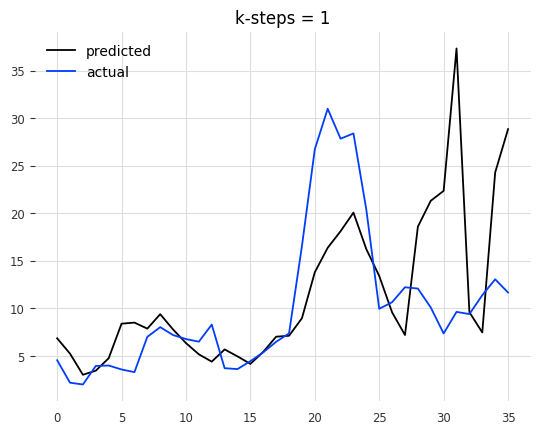

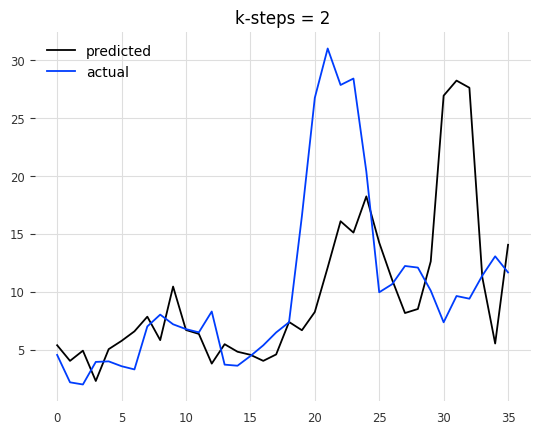

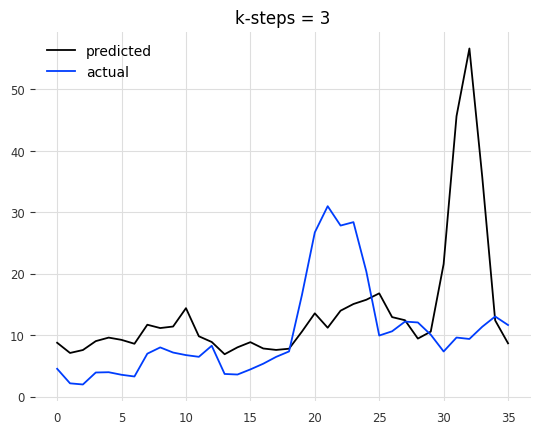

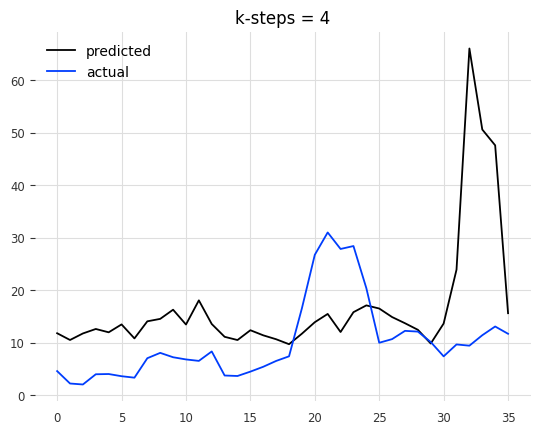

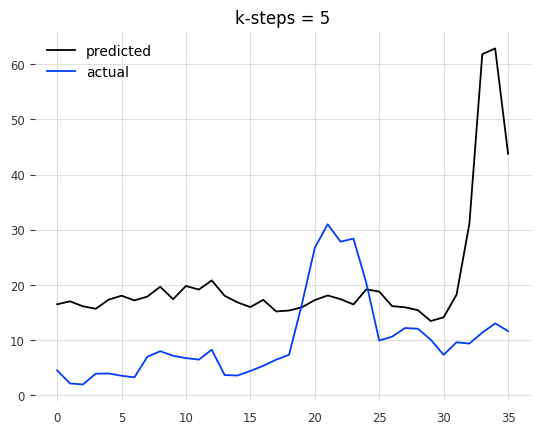

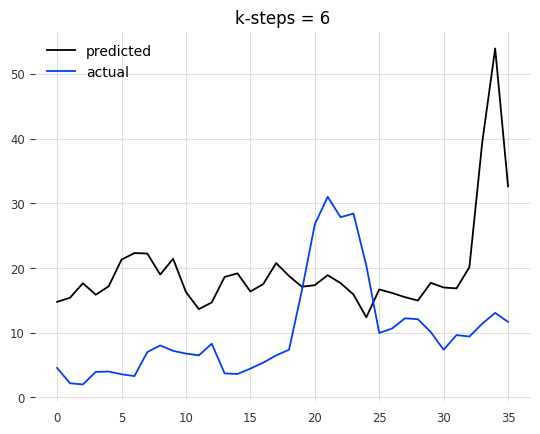

⭐️⭐️⭐️⭐️⭐️⭐️⭐️
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨
🌷🌷🌷🌷🌷🌷🌷🌷🌷
CNN

🍭🍭🍭🍭🍭
Epoch:  0/240 - train_loss: 0.8555 - test_loss: 0.648685
Epoch: 60/240 - train_loss: 0.0701 - test_loss: 0.029317
Epoch: 120/240 - train_loss: 0.0588 - test_loss: 0.020236
Epoch: 180/240 - train_loss: 0.0562 - test_loss: 0.017620
Epoch: 239/240 - train_loss: 0.0570 - test_loss: 0.017099


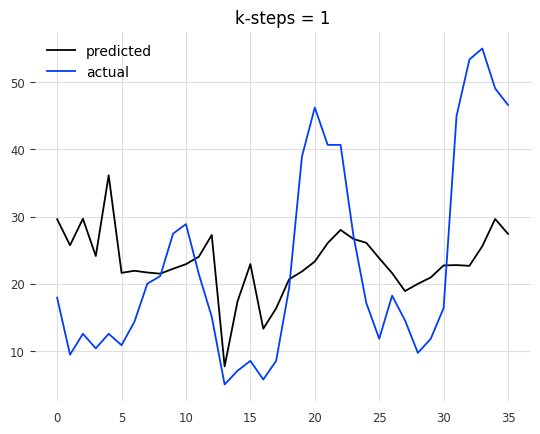

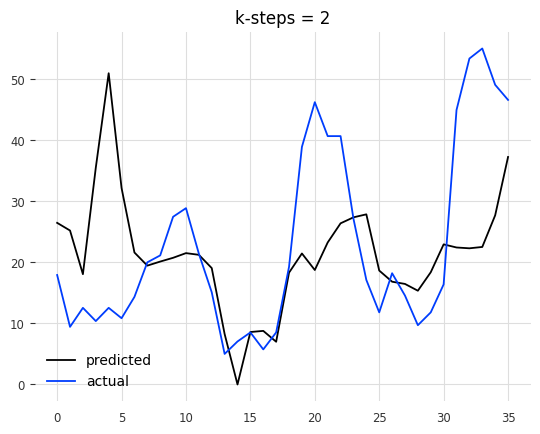

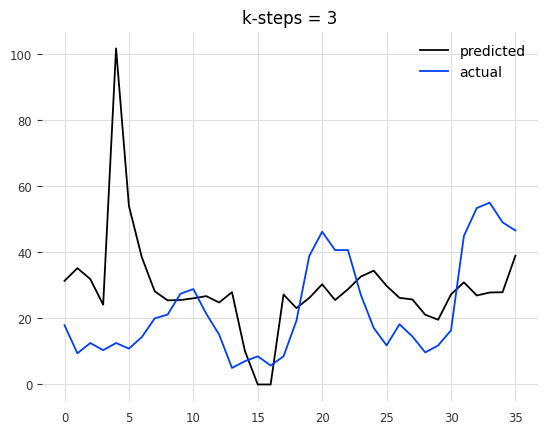

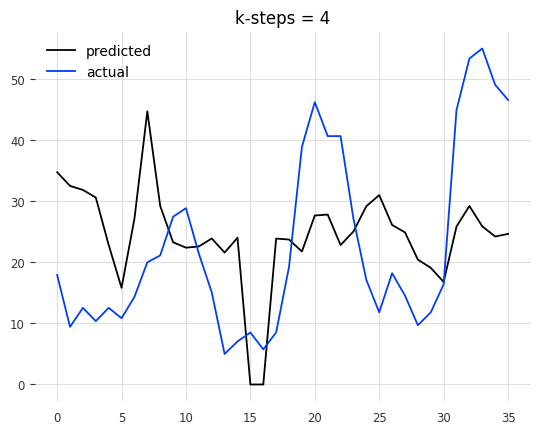

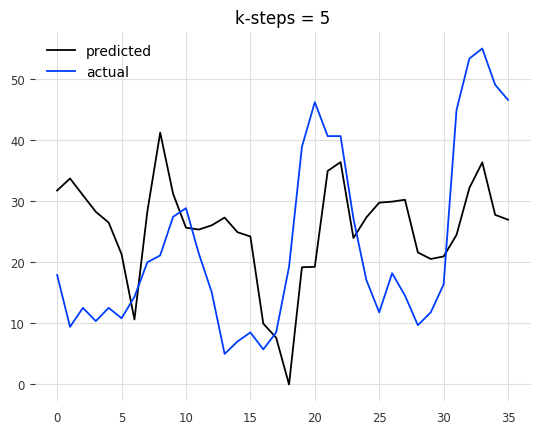

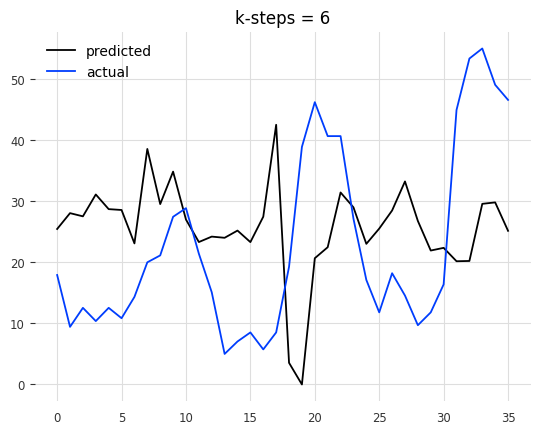

⭐️⭐️⭐️⭐️⭐️⭐️⭐️
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
🌷🌷🌷🌷🌷🌷🌷🌷🌷
CNN

🍭🍭🍭🍭🍭
Epoch:  0/110 - train_loss: 0.9642 - test_loss: 0.704512
Epoch: 27/110 - train_loss: 0.5255 - test_loss: 0.459350
Epoch: 54/110 - train_loss: 0.3375 - test_loss: 0.305100
Epoch: 81/110 - train_loss: 0.2529 - test_loss: 0.208180
Epoch: 108/110 - train_loss: 0.1863 - test_loss: 0.155372
Epoch: 109/110 - train_loss: 0.1835 - test_loss: 0.154654


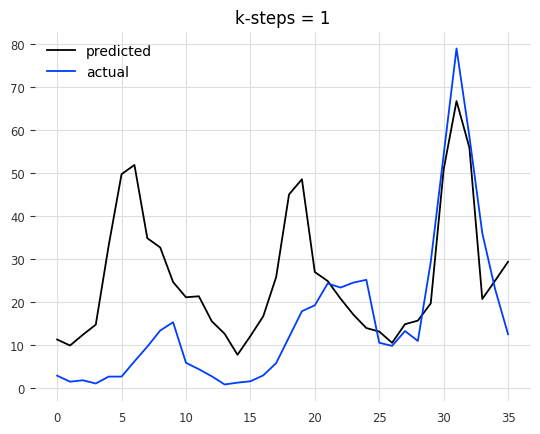

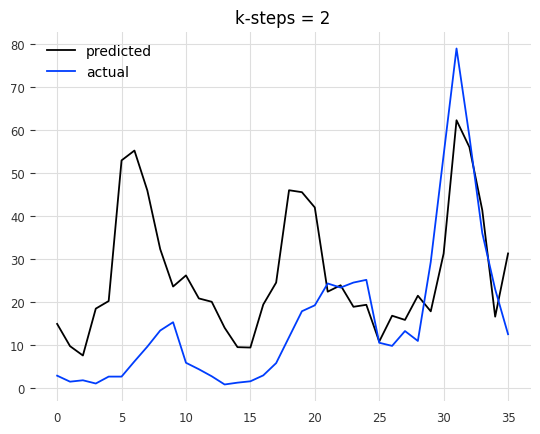

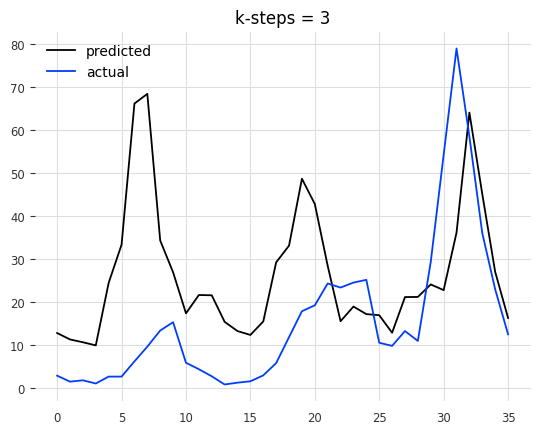

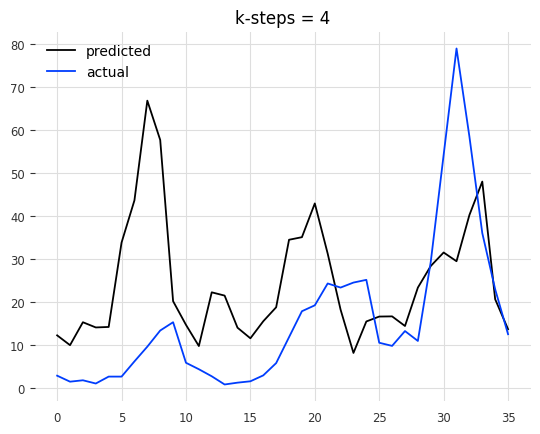

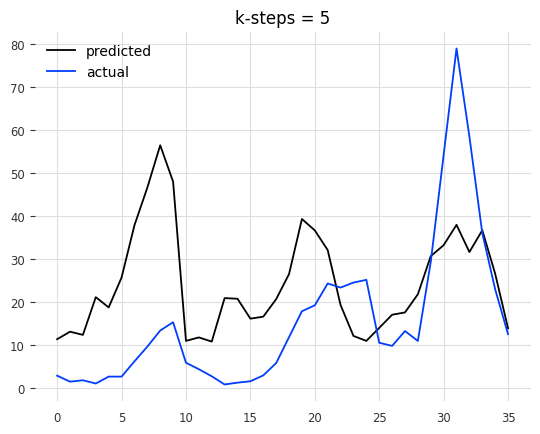

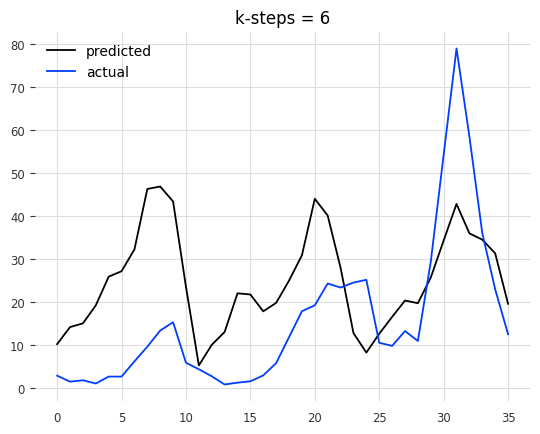

⭐️⭐️⭐️⭐️⭐️⭐️⭐️
✨✨✨✨✨✨✨✨LSTM✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM
🍭🍭🍭🍭🍭
Epoch:  0/260 - train_loss: 0.8689 - test_loss: 0.681689
Epoch: 65/260 - train_loss: 0.3582 - test_loss: 0.184569
Epoch: 130/260 - train_loss: 0.2907 - test_loss: 0.183773
Epoch: 195/260 - train_loss: 0.2719 - test_loss: 0.213243
Epoch: 259/260 - train_loss: 0.2557 - test_loss: 0.206197


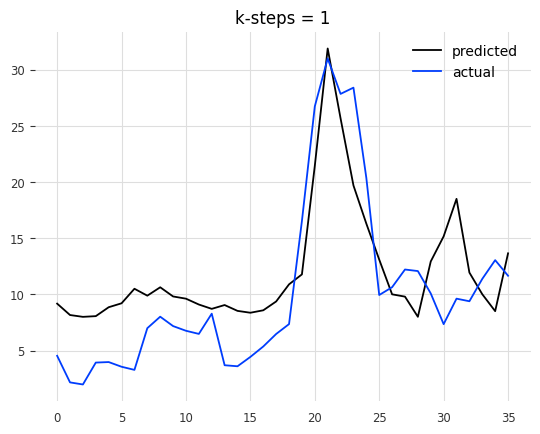

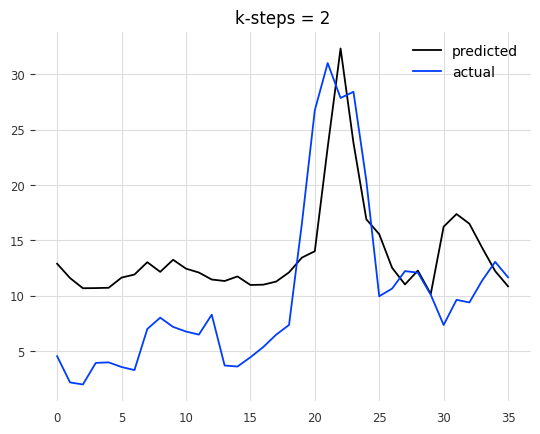

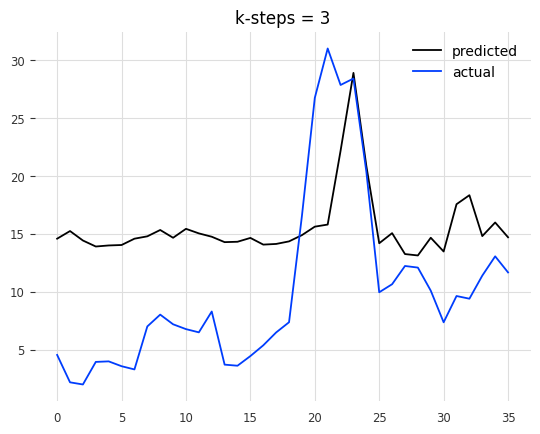

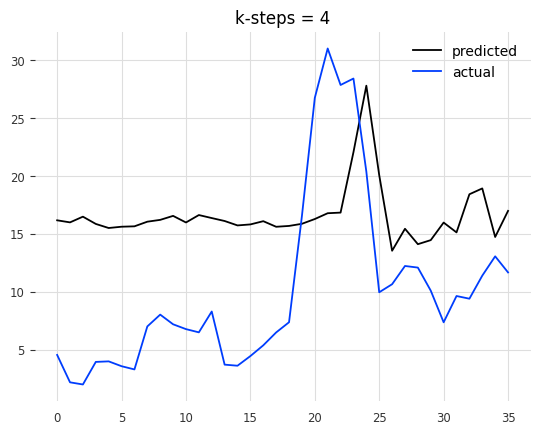

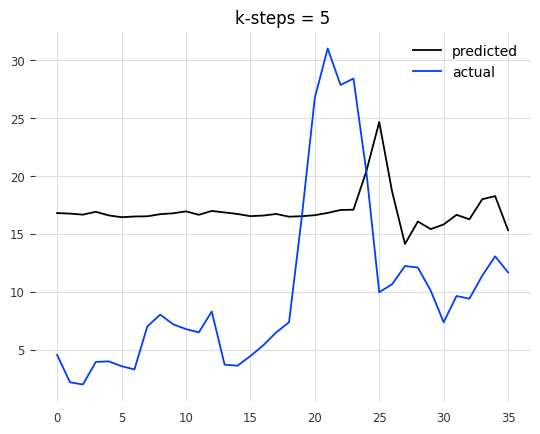

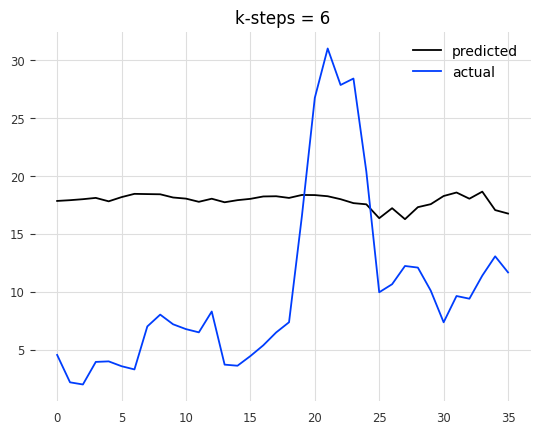

⭐️⭐️⭐️⭐️⭐️⭐️⭐️
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM
🍭🍭🍭🍭🍭
Epoch:  0/470 - train_loss: 0.7040 - test_loss: 0.676816
Epoch: 117/470 - train_loss: 0.0718 - test_loss: 0.043079


[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [865]:
model_name_list = [
    "CNN",
    "LSTM",
    "LSTM_ATT",
    "TRANSFORMERS"
]

for model_name in model_name_list:  
    print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
    for city in cities:
        seed_everything(args.seed)
        print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
        df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
        df_eval = pd.read_csv(output_process+city+'_test_preprocessed_normed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
        scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
        nstep = args.n_predicted_period_months
        selected_features = getDataWithSelectedFeature(city, nstep)
        
        train = df_train[selected_features+[args.labels]].iloc[:,:].to_numpy()
        test = df_eval[selected_features+[args.labels]].iloc[:,:].to_numpy()

        train_X, train_y = to_supervised(train, d_out=args.n_predicted_period_months, d_in=args.look_back )
        test_X, test_y = to_supervised(test, d_out=args.n_predicted_period_months, d_in=args.look_back )

        train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
        test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))
        
        
        train_loader = DataLoader(train_tensor, batch_size=args.batch_size, shuffle=True)

       
        df_hyper_params = getHyperParams(model_name, city)
        if model_name == "CNN":
            #suggest hyperparams
            args.epochs = df_hyper_params['Epochs'].values[0]
            learning_rate = df_hyper_params['Learning rate'].values[0]
            num_filters = df_hyper_params['Num. filters'].values[0].split(',')
            num_filters = [int(i) for i in num_filters]
            dropout = df_hyper_params['Dropout rate'].values[0]

            trainer = Trainer(model_type='CNN',
                    learning_rate=learning_rate,
                    important_features=selected_features,
                    train_loader=train_loader,
                    test_tensor=test_tensor,
                    num_filters=num_filters, 
                    dropout=dropout)
        elif model_name == 'LSTM':
            args.epochs = df_hyper_params['Epochs'].values[0]
            hidden_size = df_hyper_params['Hiden Size'].values[0]
            n_layers = df_hyper_params['n Layers'].values[0]
            learning_rate = df_hyper_params['Learning rate'].values[0]
            trainer = Trainer(model_type='LSTM',
                                    learning_rate=learning_rate,
                                    important_features=selected_features,
                                    train_loader=train_loader,
                                    test_tensor=test_tensor,
                                    n_layers=n_layers,
                                    hidden_size=hidden_size,
                                    look_back = args.look_back)
        elif model_name == 'LSTM_ATT':
            args.epochs = df_hyper_params['Epochs'].values[0]
            hidden_size = df_hyper_params['Hiden Size'].values[0]
            n_layers = df_hyper_params['n Layers'].values[0]
            learning_rate = df_hyper_params['Learning rate'].values[0]
            trainer = Trainer(model_type='LSTM_ATT',
                                    learning_rate=learning_rate,
                                    important_features=selected_features,
                                    train_loader=train_loader,
                                    test_tensor=test_tensor,
                                    n_layers=n_layers,
                                    hidden_size=hidden_size,
                                    look_back = args.look_back)
        elif model_name == 'TRANSFORMERS':
            n_layers = df_hyper_params['n Layers'].values[0]
            hidden_size = df_hyper_params['Hidden Size'].values[0]
            learning_rate = df_hyper_params['Learning rate'].values[0]
            dropout = df_hyper_params['Dropout rate'].values[0]
            args.epochs = df_hyper_params['Epochs'].values[0]

            trainer = Trainer(model_type='TRANSFORMERS',
                        important_features=selected_features,
                        train_loader=train_loader,
                        test_tensor=test_tensor,
                        n_layers=n_layers,
                        hidden_size=hidden_size,
                        learning_rate=learning_rate,
                        dropout=dropout)
            
        trainer.train(epochs=args.epochs)
        

        df_results = trainer.evaluate_model(np_data=test, df_eval = df_eval, plot= True, scaled=True, city=city, scaler = scaler)

        result_columns = ['Date', 'City', 'Observed',
                            'MSE_1-month', 'MAE_1-month', 'RMSE_1-month', 'MAPE_1-month',  
                            'MSE_2-month', 'MAE_2-month', 'RMSE_2-month', 'MAPE_2-month',  
                            'MSE_3-month', 'MAE_3-month', 'RMSE_3-month', 'MAPE_3-month',
                            'MSE_4-month', 'MAE_4-month', 'RMSE_4-month', 'MAPE_4-month', 
                            'MSE_5-month', 'MAE_5-month', 'RMSE_5-month', 'MAPE_5-month',  
                            'MSE_6-month', 'MAE_6-month', 'RMSE_6-month', 'MAPE_6-month',
                            '1-month', '2-month', '3-month', '4-month', '5-month', '6-month', 
                            ]
        df_results = df_results.reset_index()[result_columns]
        
        folder_save_rs_path = f"./predict_results/{model_name}/"
        folder_save_model_path = f"./trained_models/{model_name}/"
        if not (os.path.isdir(folder_save_rs_path)):
            os.makedirs(folder_save_rs_path, exist_ok=True)
        if not (os.path.isdir(folder_save_model_path)):
            os.makedirs(folder_save_model_path, exist_ok=True)
        df_results.to_excel(f"{folder_save_rs_path}0_{nstep}_nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
        torch.save(trainer.model.state_dict(), f"{folder_save_model_path}{nstep}nstep_denguefever_{model_name}_in_{city}.pth")